In [1]:
import pandas as pd
import geopandas as gpd
import requests
from shapely import Point
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
def getPoles(url):
    _response = requests.get(url)
    _tmp = (pd.DataFrame([row.split(' ') for 
                          row in _response.content.decode().split('\n')],
                         columns=['lon','lat','year']))
    _tmp = _tmp.dropna()
    for _col in _tmp.columns:
        _tmp[_col] = _tmp[_col].astype(float)
        
    _tmp['geometry'] = _tmp.apply(lambda q: Point(q['lon'], q['lat']), axis=1)
    return gpd.GeoDataFrame(_tmp, crs=4326)

In [3]:
## https://www.ncei.noaa.gov/products/wandering-geomagnetic-poles

np_url = 'https://www.ngdc.noaa.gov/geomag/data/poles/NP.xy'
sp_url = 'https://www.ngdc.noaa.gov/geomag/data/poles/SP.xy'

n = getPoles(np_url)
s = getPoles(sp_url)

n_crs = ccrs.NorthPolarStereo(central_longitude=0)
s_crs = ccrs.SouthPolarStereo(central_longitude=0)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\s1759665\AppData\Local\Temp\ipykernel_20692\4151661650.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


C:\Users\s1759665\AppData\Local\Temp\ipykernel_20692\609142715.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


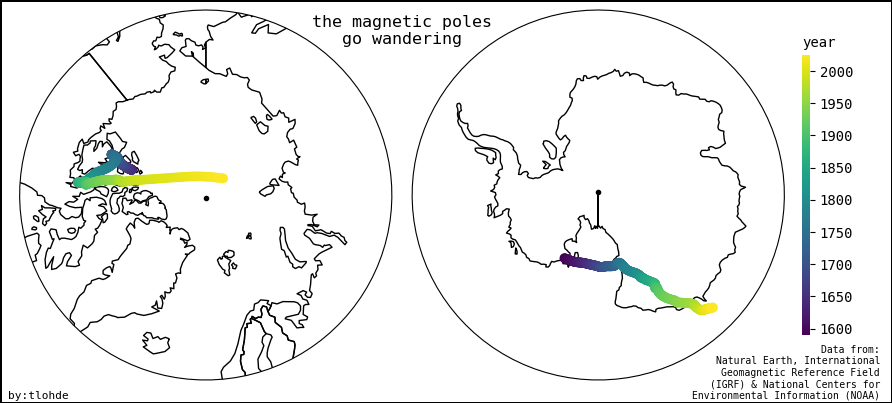

In [4]:
fig = plt.figure(figsize=[8,4], edgecolor='k', linewidth=2)
gs = fig.add_gridspec(1,2)

# make axes with different projections
ax1 = fig.add_subplot(gs[0,0], projection=n_crs)
ax2 = fig.add_subplot(gs[0,1], projection=s_crs)

# just plot the northern and southern hemispheres
world.cx[:,0:].to_crs(n_crs).plot(ax=ax1,fc='none')
world.cx[:,-90:0].to_crs(s_crs).plot(ax=ax2,fc='none')

## plot the polar wander pooints, coloured by year
n.to_crs(n_crs).plot(ax=ax1, column='year')
s.to_crs(s_crs).plot(ax=ax2, column='year')

## add a dot for the poles, and crop extent to 60 degrees
# ax1.gridlines()
ax1.scatter(0,0, c='k', marker = '.')
ax1.set_extent([-180,180,60,90], ccrs.PlateCarree())

# ax2.gridlines()
ax2.scatter(0,0, c='k', marker = '.')
ax2.set_extent([-180,180,-90,-60], ccrs.PlateCarree())

# force axes to be circular
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax1.set_boundary(circle, transform=ax1.transAxes)
ax2.set_boundary(circle, transform=ax2.transAxes)

# construct common colour map
cmap = plt.cm.viridis
norm = Normalize(vmin=n['year'].min(),
                 vmax=n['year'].max())

cax = fig.add_axes([1, 0.15, 0.01, 0.7])
cb = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, shrink=0.6, pad=0)
cb.outline.set_visible(False)
cax.set_title('year', loc='left', fontdict={'font':'DejaVu Sans Mono'})
cax.set_yticks(cax.get_yticks()[1:-1],
               labels = cax.get_yticklabels()[1:-1],
               font='DejaVu Sans Mono')
plt.tight_layout()

## annotations etc...
plt.annotate(text='by:tlohde',
            xy=(0.01,0.01), xycoords='figure fraction', fontsize=8, font='DejaVu Sans Mono')

plt.annotate(text='Data from:\nNatural Earth, International\nGeomagnetic Reference Field\n(IGRF) & National Centers for\nEnvironmental Information (NOAA)',
            xy=(1.1,0.01), xycoords='figure fraction', fontsize=7, ha='right', font='DejaVu Sans Mono')

fig.suptitle('the magnetic poles\ngo wandering', y=0.95, fontdict={'font':'DejaVu Sans Mono'})

fig.patch.set_edgecolor('k')
fig.savefig('day7.png', bbox_inches='tight', dpi=300, edgecolor=fig.get_edgecolor())